# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Haoyang Fang"
student2 = "Jiatai Qiang"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

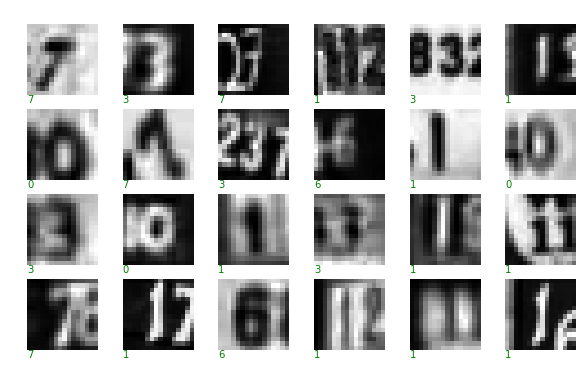

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Train on 35565 samples, validate on 12735 samples
Epoch 1/100
 - 1s - loss: 1.5893 - acc: 0.2939 - val_loss: 1.5777 - val_acc: 0.3238
Epoch 2/100
 - 0s - loss: 1.5810 - acc: 0.2949 - val_loss: 1.5709 - val_acc: 0.3216
Epoch 3/100
 - 0s - loss: 1.5752 - acc: 0.2952 - val_loss: 1.5646 - val_acc: 0.3216
Epoch 4/100
 - 0s - loss: 1.5706 - acc: 0.2962 - val_loss: 1.5613 - val_acc: 0.3311
Epoch 5/100
 - 0s - loss: 1.5670 - acc: 0.2993 - val_loss: 1.5560 - val_acc: 0.3285
Epoch 6/100
 - 0s - loss: 1.5637 - acc: 0.3016 - val_loss: 1.5531 - val_acc: 0.3320
Epoch 7/100
 - 0s - loss: 1.5610 - acc: 0.3045 - val_loss: 1.5519 - val_acc: 0.3368
Epoch 8/100
 - 0s - loss: 1.5585 - acc: 0.3059 - val_loss: 1.5492 - val_acc: 0.3364
Epoch 9/100
 - 0s - loss: 1.5564 - acc: 0.3080 - val_loss: 1.5475 - val_acc: 0.3435
Epoch 10/100
 - 0s - loss: 1.5545 - acc: 0.3108 - val_loss: 1.5458 - val_acc: 0.3406
Epoch 11/100
 - 0s - loss: 1.5526 - acc: 0.3120 - val_loss: 1.5447 - val_acc: 0.3444
Epoch 12/100
 - 0s - los

Epoch 97/100
 - 0s - loss: 1.5114 - acc: 0.3573 - val_loss: 1.5464 - val_acc: 0.3693
Epoch 98/100
 - 0s - loss: 1.5112 - acc: 0.3582 - val_loss: 1.5459 - val_acc: 0.3668
Epoch 99/100
 - 0s - loss: 1.5111 - acc: 0.3573 - val_loss: 1.5464 - val_acc: 0.3690
Epoch 100/100
 - 0s - loss: 1.5110 - acc: 0.3579 - val_loss: 1.5469 - val_acc: 0.3693


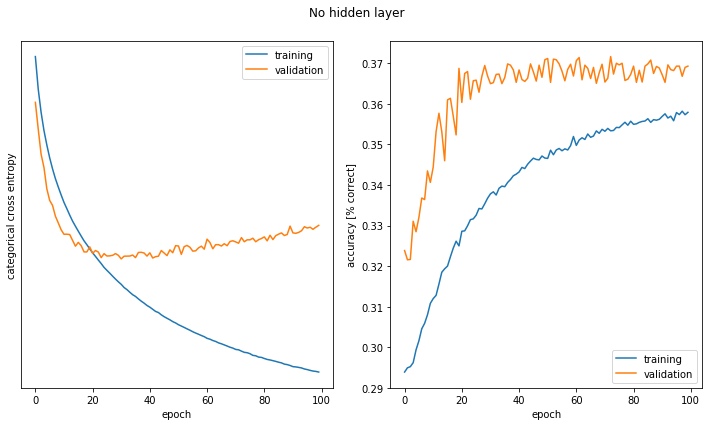

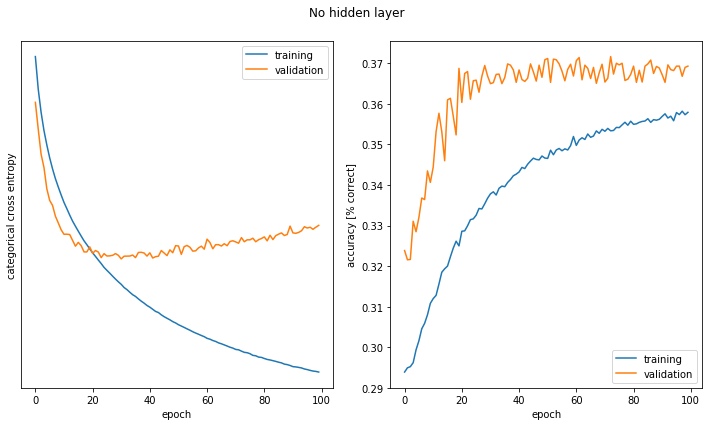

In [8]:
from random import shuffle

model = Sequential()
model.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=16*16))
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=128, epochs=100, verbose=2, validation_data=(x_test, y_test))

plot_history(hist, "No hidden layer")


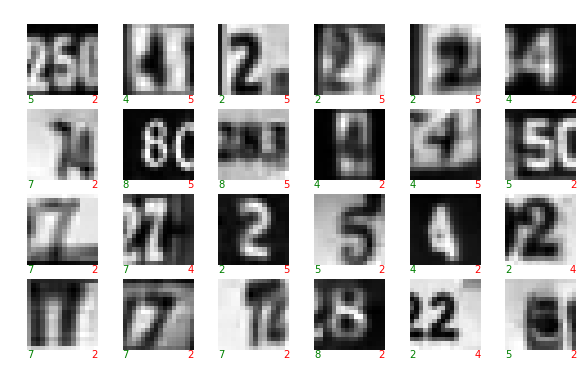

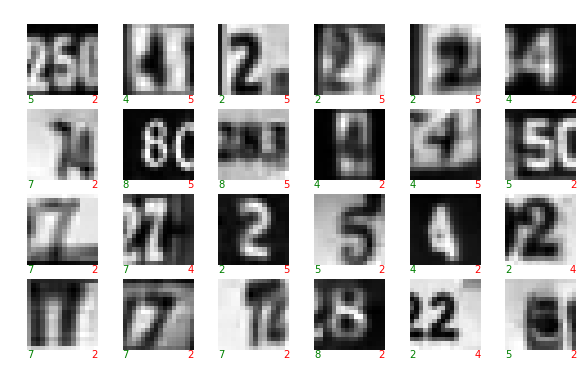

In [9]:
pred = model.predict(x_test)
ind = pred.argmax(axis=1)
yhat_test = np.zeros_like(pred)
yhat_test[range(yhat_test.shape[0]),ind] = 1

error_indices = np.where(yhat_test != y_test)[0][::2]
shuffle(error_indices)

plot_some_samples(x_test, y_test, yhat_test, error_indices[:24], label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [10]:
model = Sequential()
hidden_size = 64
model.add(Dense(hidden_size, activation='relu' ,input_dim=16*16))
model.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=hidden_size))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [11]:
sgd = SGD(lr=6e-2)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=2, validation_data=(x_test, y_test))

Train on 35565 samples, validate on 12735 samples
Epoch 1/50
 - 1s - loss: 1.5601 - acc: 0.3079 - val_loss: 1.5165 - val_acc: 0.3424
Epoch 2/50
 - 1s - loss: 1.4926 - acc: 0.3606 - val_loss: 1.4302 - val_acc: 0.4427
Epoch 3/50
 - 1s - loss: 1.3827 - acc: 0.4513 - val_loss: 1.3098 - val_acc: 0.5069
Epoch 4/50
 - 1s - loss: 1.2536 - acc: 0.5232 - val_loss: 1.1960 - val_acc: 0.5416
Epoch 5/50
 - 0s - loss: 1.1416 - acc: 0.5751 - val_loss: 1.1176 - val_acc: 0.5748
Epoch 6/50
 - 1s - loss: 1.0516 - acc: 0.6198 - val_loss: 1.0318 - val_acc: 0.6090
Epoch 7/50
 - 1s - loss: 0.9764 - acc: 0.6572 - val_loss: 0.9890 - val_acc: 0.6616
Epoch 8/50
 - 1s - loss: 0.9151 - acc: 0.6873 - val_loss: 0.9332 - val_acc: 0.6781
Epoch 9/50
 - 1s - loss: 0.8663 - acc: 0.7115 - val_loss: 0.9094 - val_acc: 0.6740
Epoch 10/50
 - 1s - loss: 0.8262 - acc: 0.7278 - val_loss: 0.8727 - val_acc: 0.7096
Epoch 11/50
 - 1s - loss: 0.7946 - acc: 0.7427 - val_loss: 0.8652 - val_acc: 0.7164
Epoch 12/50
 - 1s - loss: 0.7683 - 

In [12]:
model2 = Sequential()
hidden_size = 64
model2.add(Dense(hidden_size, activation='relu' ,input_dim=16*16))
model2.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=hidden_size))
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist2 = model2.fit(x_train, y_train, batch_size=128, epochs=50, verbose=2, validation_data=(x_test, y_test))

Train on 35565 samples, validate on 12735 samples
Epoch 1/50
 - 1s - loss: 1.4387 - acc: 0.4145 - val_loss: 1.1904 - val_acc: 0.5793
Epoch 2/50
 - 1s - loss: 1.0406 - acc: 0.6585 - val_loss: 0.9489 - val_acc: 0.6714
Epoch 3/50
 - 1s - loss: 0.8525 - acc: 0.7296 - val_loss: 0.8596 - val_acc: 0.7260
Epoch 4/50
 - 1s - loss: 0.7670 - acc: 0.7610 - val_loss: 0.8154 - val_acc: 0.7402
Epoch 5/50
 - 1s - loss: 0.7170 - acc: 0.7771 - val_loss: 0.8152 - val_acc: 0.7414
Epoch 6/50
 - 1s - loss: 0.6829 - acc: 0.7879 - val_loss: 0.7724 - val_acc: 0.7545
Epoch 7/50
 - 1s - loss: 0.6550 - acc: 0.7971 - val_loss: 0.7682 - val_acc: 0.7604
Epoch 8/50
 - 1s - loss: 0.6343 - acc: 0.8021 - val_loss: 0.7824 - val_acc: 0.7540
Epoch 9/50
 - 1s - loss: 0.6075 - acc: 0.8114 - val_loss: 0.7201 - val_acc: 0.7725
Epoch 10/50
 - 1s - loss: 0.5908 - acc: 0.8173 - val_loss: 0.7016 - val_acc: 0.7823
Epoch 11/50
 - 1s - loss: 0.5705 - acc: 0.8235 - val_loss: 0.6830 - val_acc: 0.7873
Epoch 12/50
 - 1s - loss: 0.5531 - 

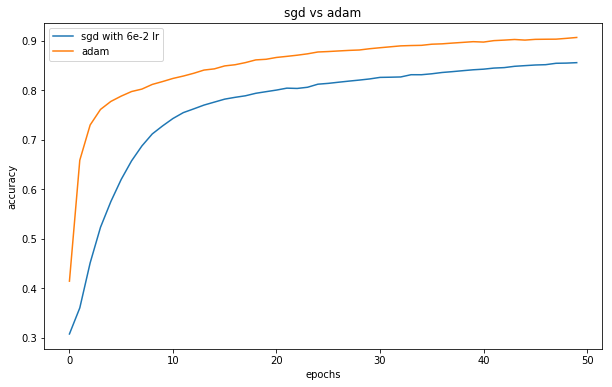

In [13]:
plt.title("sgd vs adam")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(hist.history['acc'], label = "sgd with 6e-2 lr")
plt.plot(hist2.history['acc'], label = "adam")
plt.legend(loc='best')
plt.show()

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) cannot converge (to the minima)

B) converge too slowly

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

Train on 35565 samples, validate on 12735 samples
Epoch 1/120
 - 1s - loss: 1.4459 - acc: 0.4150 - val_loss: 1.2288 - val_acc: 0.5636
Epoch 2/120
 - 1s - loss: 1.0747 - acc: 0.6320 - val_loss: 0.9682 - val_acc: 0.6710
Epoch 3/120
 - 1s - loss: 0.8726 - acc: 0.7217 - val_loss: 0.8615 - val_acc: 0.7099
Epoch 4/120
 - 1s - loss: 0.7815 - acc: 0.7550 - val_loss: 0.8272 - val_acc: 0.7254
Epoch 5/120
 - 1s - loss: 0.7279 - acc: 0.7759 - val_loss: 0.7968 - val_acc: 0.7464
Epoch 6/120
 - 1s - loss: 0.6935 - acc: 0.7873 - val_loss: 0.7868 - val_acc: 0.7545
Epoch 7/120
 - 1s - loss: 0.6632 - acc: 0.7948 - val_loss: 0.7499 - val_acc: 0.7668
Epoch 8/120
 - 1s - loss: 0.6408 - acc: 0.8011 - val_loss: 0.7378 - val_acc: 0.7727
Epoch 9/120
 - 1s - loss: 0.6201 - acc: 0.8079 - val_loss: 0.7145 - val_acc: 0.7795
Epoch 10/120
 - 1s - loss: 0.6022 - acc: 0.8145 - val_loss: 0.7071 - val_acc: 0.7831
Epoch 11/120
 - 1s - loss: 0.5860 - acc: 0.8197 - val_loss: 0.6866 - val_acc: 0.7921
Epoch 12/120
 - 1s - los

Epoch 97/120
 - 1s - loss: 0.2435 - acc: 0.9266 - val_loss: 0.5062 - val_acc: 0.8847
Epoch 98/120
 - 1s - loss: 0.2438 - acc: 0.9258 - val_loss: 0.4992 - val_acc: 0.8843
Epoch 99/120
 - 1s - loss: 0.2433 - acc: 0.9267 - val_loss: 0.5126 - val_acc: 0.8816
Epoch 100/120
 - 1s - loss: 0.2427 - acc: 0.9251 - val_loss: 0.5107 - val_acc: 0.8829
Epoch 101/120
 - 1s - loss: 0.2422 - acc: 0.9266 - val_loss: 0.5047 - val_acc: 0.8848
Epoch 102/120
 - 1s - loss: 0.2432 - acc: 0.9266 - val_loss: 0.5198 - val_acc: 0.8814
Epoch 103/120
 - 1s - loss: 0.2396 - acc: 0.9284 - val_loss: 0.5224 - val_acc: 0.8788
Epoch 104/120
 - 1s - loss: 0.2364 - acc: 0.9275 - val_loss: 0.5246 - val_acc: 0.8817
Epoch 105/120
 - 1s - loss: 0.2382 - acc: 0.9262 - val_loss: 0.5206 - val_acc: 0.8802
Epoch 106/120
 - 1s - loss: 0.2357 - acc: 0.9291 - val_loss: 0.5058 - val_acc: 0.8856
Epoch 107/120
 - 1s - loss: 0.2347 - acc: 0.9296 - val_loss: 0.5149 - val_acc: 0.8828
Epoch 108/120
 - 1s - loss: 0.2353 - acc: 0.9285 - val_lo

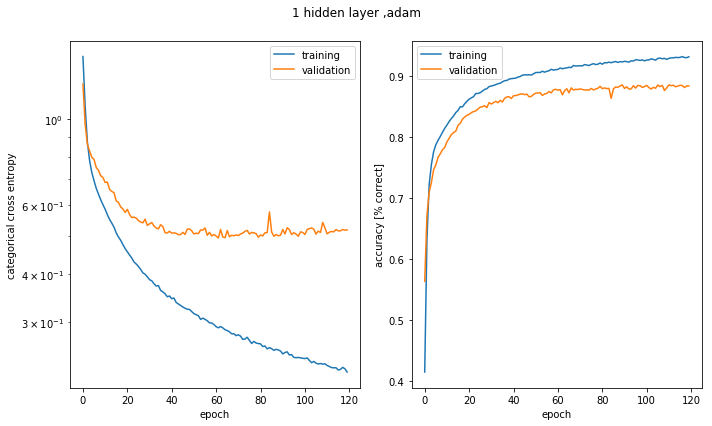

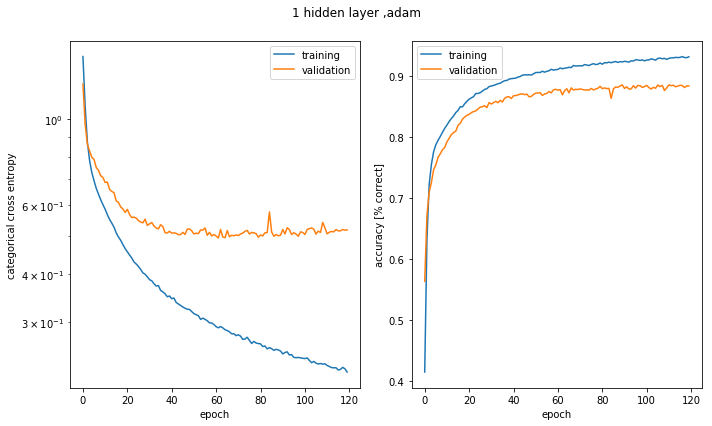

In [14]:
model2 = Sequential()
hidden_size = 64
model2.add(Dense(hidden_size, activation='relu' ,input_dim=16*16))
model2.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=hidden_size))
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist2 = model2.fit(x_train, y_train, batch_size=128, epochs=120, verbose=2, validation_data=(x_test, y_test))
plot_history(hist2, "1 hidden layer ,adam")

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: At around 70th epoch, the model start to overfit.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: Traning loss curve keep decreasing but validation loss curve stay still. Training acc curve keep increasing but validation acc curve stay still.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [15]:
list_hidden = np.array(range(10)) * 100 + 10 #TO BE MODIFIED
list_hidden = [10, 20, 40, 80, 160, 320, 640, 1000]
repeat = 15 #running times for a model
#hist contains 4 list: final_loss_hist,stop_loss_hist,final_acc_hist,stop_acc_hist
hist = [[],[],[],[]]
for hidden_size in list_hidden:
    for i in range(4):
        hist[i].append([])
    for i in range(repeat):
        model = Sequential()
        model.add(Dense(hidden_size, activation='relu' ,input_dim=16*16))
        model.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=hidden_size))
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(x_train, y_train, batch_size=128, epochs=100, verbose = 0, validation_data=(x_test, y_test))
        ind = np.argmin(history.history['val_loss']) #early stop index
        hist[0][-1].append(history.history['val_loss'][-1])
        hist[1][-1].append(history.history['val_loss'][ind])
        hist[2][-1].append(history.history['val_acc'][-1])
        hist[3][-1].append(history.history['val_acc'][ind])
        print("Finish the",i+1,"th running of hidden size",hidden_size)

Finish the 1 th running of hidden size 10
Finish the 2 th running of hidden size 10
Finish the 3 th running of hidden size 10
Finish the 4 th running of hidden size 10
Finish the 5 th running of hidden size 10
Finish the 6 th running of hidden size 10
Finish the 7 th running of hidden size 10
Finish the 8 th running of hidden size 10
Finish the 9 th running of hidden size 10
Finish the 10 th running of hidden size 10
Finish the 11 th running of hidden size 10
Finish the 12 th running of hidden size 10
Finish the 13 th running of hidden size 10
Finish the 14 th running of hidden size 10
Finish the 15 th running of hidden size 10
Finish the 1 th running of hidden size 20
Finish the 2 th running of hidden size 20
Finish the 3 th running of hidden size 20
Finish the 4 th running of hidden size 20
Finish the 5 th running of hidden size 20
Finish the 6 th running of hidden size 20
Finish the 7 th running of hidden size 20
Finish the 8 th running of hidden size 20
Finish the 9 th running of h

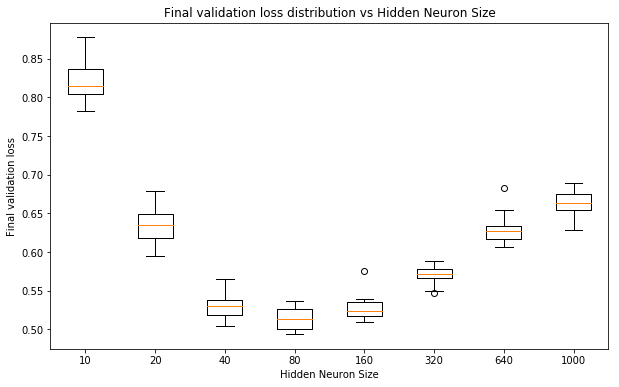

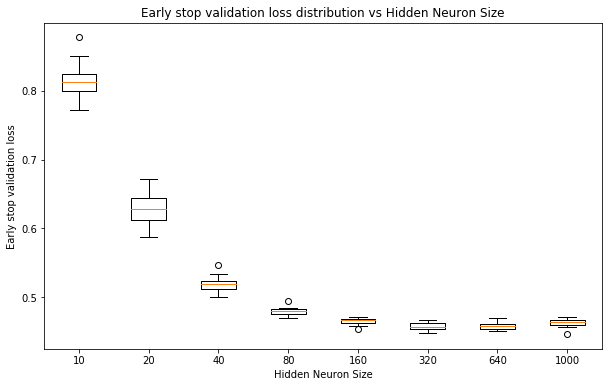

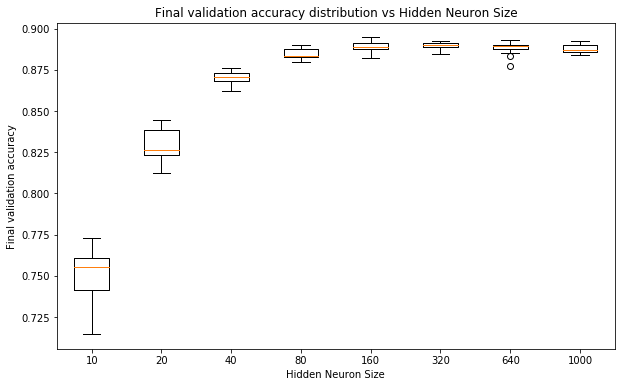

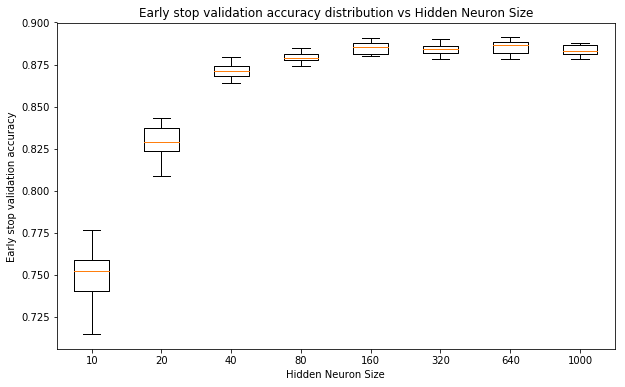

In [16]:
graph_label = ["Final validation loss distribution vs Hidden Neuron Size",
               "Early stop validation loss distribution vs Hidden Neuron Size",
               "Final validation accuracy distribution vs Hidden Neuron Size",
               "Early stop validation accuracy distribution vs Hidden Neuron Size"]
x_label = "Hidden Neuron Size"
y_label = ["Final validation loss",
               "Early stop validation loss",
               "Final validation accuracy",
               "Early stop validation accuracy"]
for i in range(4):
    plt.figure()
    plt.title(graph_label[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label[i])
    plt.boxplot(hist[i], vert=True)
    plt.xticks([i+1 for i in range(len(list_hidden))], list_hidden)

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [17]:
#loss, acc
hist = [[[],[],[],[]],[[],[],[],[]]]
repeat = 10

In [18]:
hidden_size = [100,77,66,59]
for num_hidden_layers in range(1,5):
    for i in range(repeat):
        if i == 0:
            print("Start model with",num_hidden_layers,"hidden layers with",hidden_size[num_hidden_layers-1],"hidden neurons each layer")
        model = Sequential()
        model.add(Dense(hidden_size[num_hidden_layers-1], activation='relu' ,input_dim=16*16))
        for j in range(num_hidden_layers-1):
            model.add(Dense(hidden_size[num_hidden_layers-1], activation='relu' ,input_dim=hidden_size[num_hidden_layers-1]))
        model.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=hidden_size[num_hidden_layers-1]))
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        if i == 0:
            model.summary()
        history = model.fit(x_train, y_train, batch_size=128, epochs=100, verbose = 0, validation_data=(x_test, y_test))
        ind = np.argmin(history.history['val_loss']) #early stop index
        hist[0][num_hidden_layers-1].append(history.history['val_loss'][ind])
        hist[1][num_hidden_layers-1].append(history.history['val_acc'][ind])
        print("Finish the",i+1,"th running")
        

Start model with 1 hidden layers with 100 hidden neurons each layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_248 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_249 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Finish the 1 th running
Finish the 2 th running
Finish the 3 th running
Finish the 4 th running
Finish the 5 th running
Finish the 6 th running
Finish the 7 th running
Finish the 8 th running
Finish the 9 th running
Finish the 10 th running
Start model with 2 hidden layers with 77 hidden neurons each layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)         

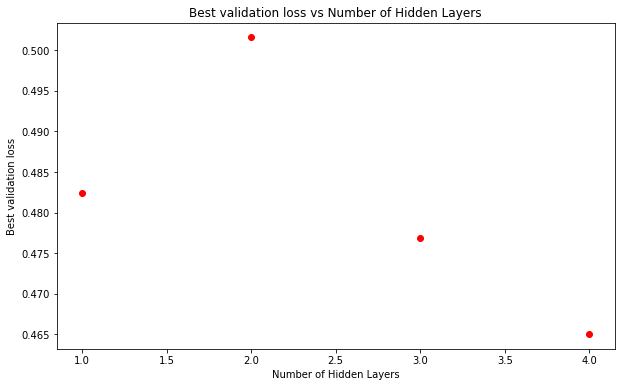

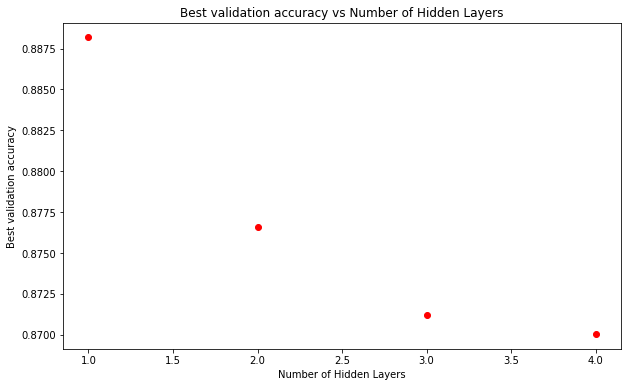

In [19]:
#word 'best' is ambiguous here, I choose the best among all early stop loss/acc for each model and plot them
graph_label = ["Best validation loss vs Number of Hidden Layers",
               "Best validation accuracy vs Number of Hidden Layers"]
x_label = "Number of Hidden Layers"
y_label = ["Best validation loss",
               "Best validation accuracy"]
stat = [[0,0,0,0],[0,0,0,0]]
for i in range(2):
    for j in range(4):
        stat[i][j] = max(hist[i][j])

for i in range(2):
    plt.figure()
    plt.plot([1,2,3,4], stat[i], 'ro')
    plt.title(graph_label[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label[i])
    plt.show()

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [8]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.layers import Activation
#1 layer
model = Sequential()
model.add(Dense(100, activation='relu' ,input_dim=16*16))
model.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=100))
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
history_1 = model.fit(x_train, y_train, batch_size=128, epochs=70, verbose = 2, validation_data=(x_test, y_test))
#1 layer
model = Sequential()
model.add(Dense(100 ,input_dim=16*16,
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l1(0.001)))
model.add(BatchNormalization())
model.add(keras.layers.PReLU()) #use prelu as activation
model.add(Dropout(0.10))
model.add(Dense(len(subset_of_classes),input_dim=100))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
history_2 = model.fit(x_train, y_train, batch_size=128, epochs=70, verbose = 2, validation_data=(x_test, y_test))
#4 layers
model = Sequential()
model.add(Dense(59, activation='relu' ,input_dim=16*16))
model.add(Dense(59, activation='relu' ,input_dim=16*16))
model.add(Dense(59, activation='relu' ,input_dim=16*16))
model.add(Dense(59, activation='relu' ,input_dim=16*16))
model.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=59))
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
history_3 = model.fit(x_train, y_train, batch_size=128, epochs=70, verbose = 2, validation_data=(x_test, y_test))

#4 layers + reg
model = Sequential()
model.add(Dense(59, input_dim=16*16,
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l1(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))
model.add(Dense(59, input_dim=16*16,
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l1(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))
model.add(Dense(59, input_dim=16*16,
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l1(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))
model.add(Dense(59, input_dim=16*16, activation='relu',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l1(0.001)))
model.add(Dense(len(subset_of_classes), activation='softmax' ,input_dim=59))
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
history_4 = model.fit(x_train, y_train, batch_size=128, epochs=70, verbose = 2, validation_data=(x_test, y_test))


Train on 38628 samples, validate on 13721 samples
Epoch 1/70
 - 9s - loss: 1.3353 - acc: 0.4547 - val_loss: 1.0822 - val_acc: 0.6105
Epoch 2/70
 - 1s - loss: 0.9524 - acc: 0.6867 - val_loss: 0.8955 - val_acc: 0.6981
Epoch 3/70
 - 1s - loss: 0.7871 - acc: 0.7576 - val_loss: 0.7976 - val_acc: 0.7456
Epoch 4/70
 - 1s - loss: 0.7011 - acc: 0.7884 - val_loss: 0.7550 - val_acc: 0.7664
Epoch 5/70
 - 1s - loss: 0.6512 - acc: 0.8005 - val_loss: 0.7010 - val_acc: 0.7811
Epoch 6/70
 - 1s - loss: 0.6158 - acc: 0.8135 - val_loss: 0.6945 - val_acc: 0.7807
Epoch 7/70
 - 1s - loss: 0.5832 - acc: 0.8223 - val_loss: 0.6515 - val_acc: 0.7955
Epoch 8/70
 - 1s - loss: 0.5594 - acc: 0.8296 - val_loss: 0.6453 - val_acc: 0.8042
Epoch 9/70
 - 1s - loss: 0.5378 - acc: 0.8362 - val_loss: 0.6218 - val_acc: 0.8125
Epoch 10/70
 - 1s - loss: 0.5201 - acc: 0.8415 - val_loss: 0.6146 - val_acc: 0.8103
Epoch 11/70
 - 1s - loss: 0.5032 - acc: 0.8471 - val_loss: 0.5945 - val_acc: 0.8226
Epoch 12/70
 - 1s - loss: 0.4936 - 

Epoch 28/70
 - 1s - loss: 0.5060 - acc: 0.8541 - val_loss: 0.5611 - val_acc: 0.8531
Epoch 29/70
 - 1s - loss: 0.5014 - acc: 0.8561 - val_loss: 0.5455 - val_acc: 0.8608
Epoch 30/70
 - 1s - loss: 0.4918 - acc: 0.8597 - val_loss: 0.5599 - val_acc: 0.8510
Epoch 31/70
 - 1s - loss: 0.5007 - acc: 0.8556 - val_loss: 0.5951 - val_acc: 0.8444
Epoch 32/70
 - 1s - loss: 0.4909 - acc: 0.8576 - val_loss: 0.5508 - val_acc: 0.8600
Epoch 33/70
 - 1s - loss: 0.4866 - acc: 0.8602 - val_loss: 0.6179 - val_acc: 0.8373
Epoch 34/70
 - 1s - loss: 0.4868 - acc: 0.8619 - val_loss: 0.5540 - val_acc: 0.8555
Epoch 35/70
 - 1s - loss: 0.4947 - acc: 0.8580 - val_loss: 0.5597 - val_acc: 0.8557
Epoch 36/70
 - 1s - loss: 0.4922 - acc: 0.8577 - val_loss: 0.5531 - val_acc: 0.8618
Epoch 37/70
 - 1s - loss: 0.4897 - acc: 0.8603 - val_loss: 0.5387 - val_acc: 0.8614
Epoch 38/70
 - 1s - loss: 0.4907 - acc: 0.8604 - val_loss: 0.6628 - val_acc: 0.8187
Epoch 39/70
 - 1s - loss: 0.4827 - acc: 0.8620 - val_loss: 0.5496 - val_acc:

 - 1s - loss: 0.1926 - acc: 0.9335 - val_loss: 0.4902 - val_acc: 0.8687
Epoch 56/80
 - 1s - loss: 0.1870 - acc: 0.9351 - val_loss: 0.4791 - val_acc: 0.8677
Epoch 57/80
 - 1s - loss: 0.1831 - acc: 0.9364 - val_loss: 0.5060 - val_acc: 0.8624
Epoch 58/80
 - 1s - loss: 0.1883 - acc: 0.9364 - val_loss: 0.5085 - val_acc: 0.8654
Epoch 59/80
 - 1s - loss: 0.1821 - acc: 0.9375 - val_loss: 0.4856 - val_acc: 0.8740
Epoch 60/80
 - 1s - loss: 0.1788 - acc: 0.9380 - val_loss: 0.5304 - val_acc: 0.8658
Epoch 61/80
 - 1s - loss: 0.1754 - acc: 0.9406 - val_loss: 0.5045 - val_acc: 0.8661
Epoch 62/80
 - 1s - loss: 0.1806 - acc: 0.9385 - val_loss: 0.4893 - val_acc: 0.8732
Epoch 63/80
 - 1s - loss: 0.1739 - acc: 0.9405 - val_loss: 0.5211 - val_acc: 0.8647
Epoch 64/80
 - 1s - loss: 0.1688 - acc: 0.9419 - val_loss: 0.5188 - val_acc: 0.8626
Epoch 65/80
 - 1s - loss: 0.1744 - acc: 0.9404 - val_loss: 0.5237 - val_acc: 0.8658
Epoch 66/80
 - 1s - loss: 0.1666 - acc: 0.9432 - val_loss: 0.5358 - val_acc: 0.8624
Epoc

Epoch 73/80
 - 2s - loss: 0.4839 - acc: 0.8636 - val_loss: 0.4965 - val_acc: 0.8641
Epoch 74/80
 - 2s - loss: 0.4878 - acc: 0.8636 - val_loss: 0.5019 - val_acc: 0.8638
Epoch 75/80
 - 2s - loss: 0.4855 - acc: 0.8636 - val_loss: 0.5222 - val_acc: 0.8561
Epoch 76/80
 - 2s - loss: 0.4943 - acc: 0.8598 - val_loss: 0.5732 - val_acc: 0.8386
Epoch 77/80
 - 2s - loss: 0.4893 - acc: 0.8617 - val_loss: 0.5451 - val_acc: 0.8494
Epoch 78/80
 - 2s - loss: 0.4863 - acc: 0.8656 - val_loss: 0.5601 - val_acc: 0.8397
Epoch 79/80
 - 2s - loss: 0.4891 - acc: 0.8619 - val_loss: 0.5238 - val_acc: 0.8522
Epoch 80/80
 - 2s - loss: 0.4833 - acc: 0.8642 - val_loss: 0.5434 - val_acc: 0.8443


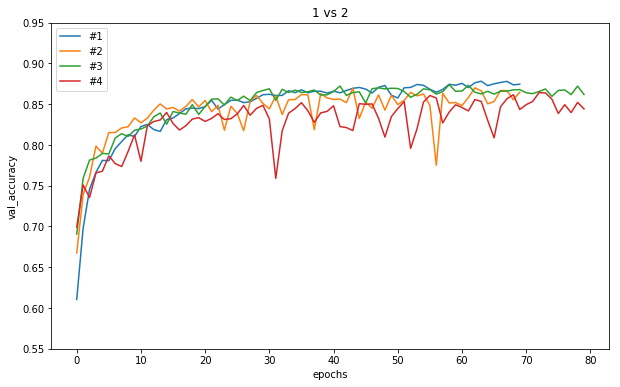

In [9]:
plt.title("1 vs 2")
plt.xlabel("epochs")
plt.ylabel("val_accuracy")
plt.ylim(0.55, 0.95)
plt.plot(history_1.history['val_acc'], label = "#1")
plt.plot(history_2.history['val_acc'], label = "#2")
plt.plot(history_3.history['val_acc'], label = "#3")
plt.plot(history_4.history['val_acc'], label = "#4")
plt.legend(loc='best')
plt.show()

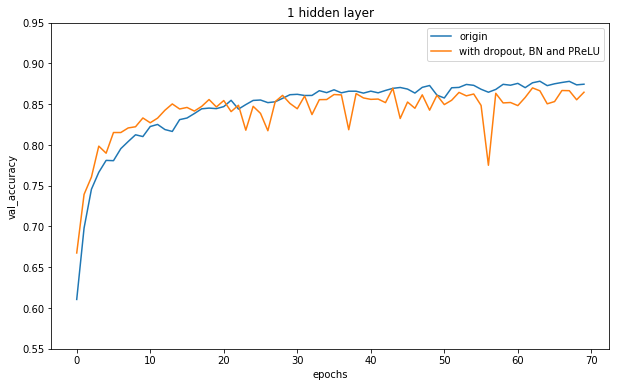

In [10]:
plt.title("1 hidden layer")
plt.xlabel("epochs")
plt.ylabel("val_accuracy")
plt.ylim(0.55, 0.95)
plt.plot(history_1.history['val_acc'], label = "origin")
plt.plot(history_2.history['val_acc'], label = "with dropout, BN and PReLU")
plt.legend(loc='best')
plt.show()

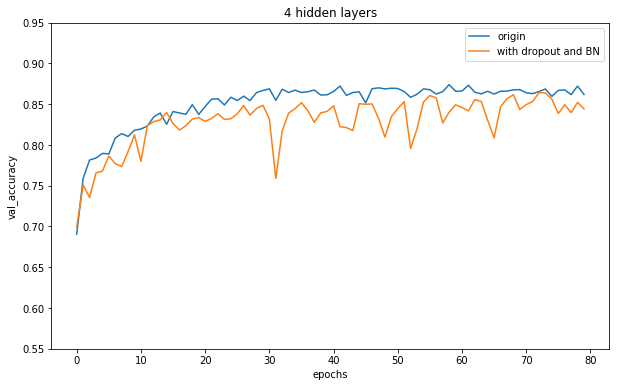

In [11]:
plt.title("4 hidden layers")
plt.xlabel("epochs")
plt.ylabel("val_accuracy")
plt.ylim(0.55, 0.95)
plt.plot(history_3.history['val_acc'], label = "origin")
plt.plot(history_4.history['val_acc'], label = "with dropout and BN")
plt.legend(loc='best')
plt.show()

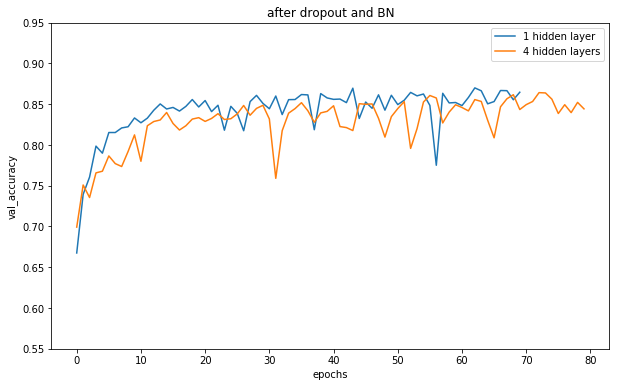

In [12]:
plt.title("after dropout and BN")
plt.xlabel("epochs")
plt.ylabel("val_accuracy")
plt.ylim(0.55, 0.95)
plt.plot(history_2.history['val_acc'], label = "1 hidden layer")
plt.plot(history_4.history['val_acc'], label = "4 hidden layers")
plt.legend(loc='best')
plt.show()

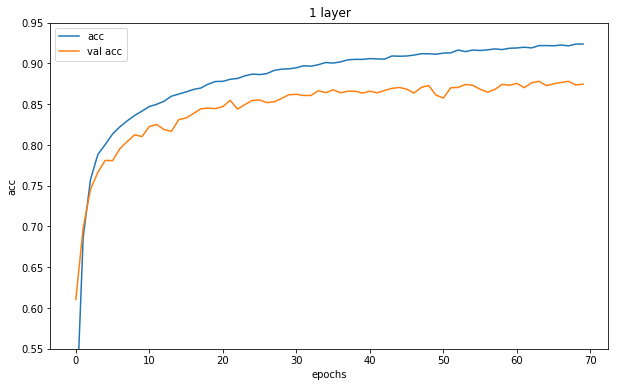

In [18]:
plt.title("1 layer")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.ylim(0.55, 0.95)
plt.plot(history_1.history['acc'], label = "acc")
plt.plot(history_1.history['val_acc'], label = "val acc")
plt.legend(loc='best')
plt.show()

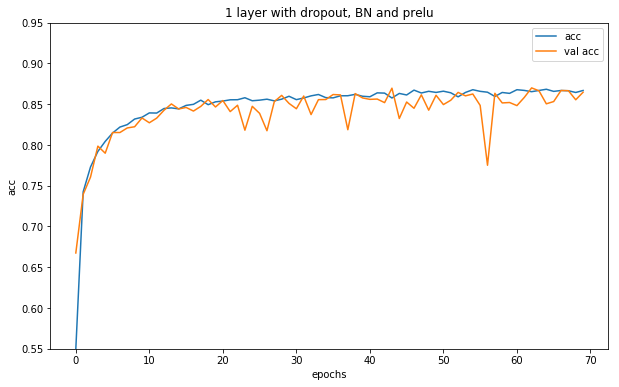

In [19]:
plt.title("1 layer with dropout, BN and prelu")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.ylim(0.55, 0.95)
plt.plot(history_2.history['acc'], label = "acc")
plt.plot(history_2.history['val_acc'], label = "val acc")
plt.legend(loc='best')
plt.show()

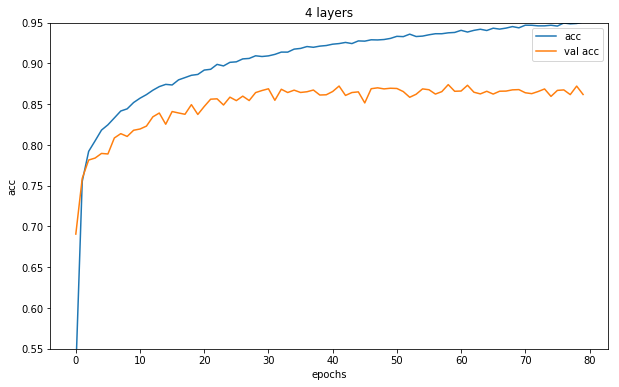

In [20]:
plt.title("4 layers")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.ylim(0.55, 0.95)
plt.plot(history_3.history['acc'], label = "acc")
plt.plot(history_3.history['val_acc'], label = "val acc")
plt.legend(loc='best')
plt.show()

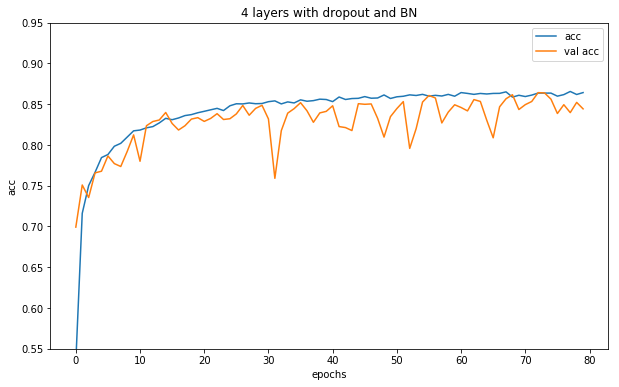

In [21]:
plt.title("4 layers with dropout and BN")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.ylim(0.55, 0.95)
plt.plot(history_4.history['acc'], label = "acc")
plt.plot(history_4.history['val_acc'], label = "val acc")
plt.legend(loc='best')
plt.show()

In [ ]:
#from the graph it's clear overfitting problem is solved.
#However, the acc/val_acc can not outperform the original one though I tried dozens of times to tune the params

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [10]:
from keras import backend as K

batch_size = 128
num_classes = len(subset_of_classes)
epochs = 20

# input image dimensions
img_rows, img_cols = 16, 16

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
hist_cnn = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))

x_train shape: (39149, 16, 16, 1)
39149 train samples
13915 test samples
Train on 39149 samples, validate on 13915 samples
Epoch 1/20
 - 11s - loss: 1.1065 - acc: 0.5551 - val_loss: 0.5709 - val_acc: 0.8378
Epoch 2/20
 - 11s - loss: 0.4858 - acc: 0.8433 - val_loss: 0.4381 - val_acc: 0.8745
Epoch 3/20
 - 11s - loss: 0.3792 - acc: 0.8757 - val_loss: 0.3657 - val_acc: 0.8895
Epoch 4/20
 - 11s - loss: 0.3307 - acc: 0.8905 - val_loss: 0.3423 - val_acc: 0.8936
Epoch 5/20
 - 11s - loss: 0.2919 - acc: 0.9020 - val_loss: 0.3174 - val_acc: 0.9014
Epoch 6/20
 - 11s - loss: 0.2667 - acc: 0.9123 - val_loss: 0.3099 - val_acc: 0.9046
Epoch 7/20
 - 11s - loss: 0.2443 - acc: 0.9171 - val_loss: 0.2936 - val_acc: 0.9094
Epoch 8/20
 - 11s - loss: 0.2263 - acc: 0.9230 - val_loss: 0.2802 - val_acc: 0.9155
Epoch 9/20
 - 11s - loss: 0.2134 - acc: 0.9281 - val_loss: 0.2701 - val_acc: 0.9179
Epoch 10/20
 - 11s - loss: 0.1996 - acc: 0.9329 - val_loss: 0.2762 - val_acc: 0.9156
Epoch 11/20
 - 11s - loss: 0.1860 - 

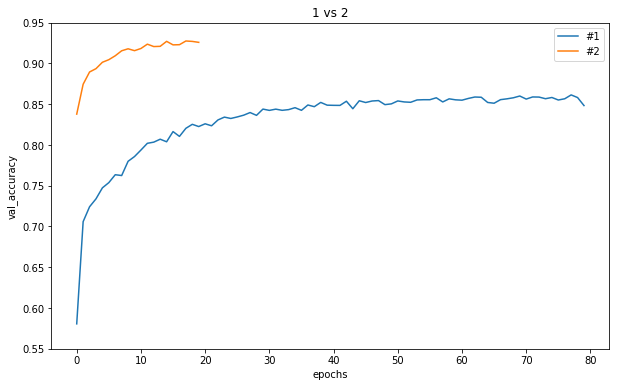

In [11]:
plt.title("1 vs 2")
plt.xlabel("epochs")
plt.ylabel("val_accuracy")
plt.ylim(0.55, 0.95)
plt.plot(history_1.history['val_acc'], label = "#1")
plt.plot(hist_cnn.history['val_acc'], label = "#2")
plt.legend(loc='best')
plt.show()